<a href="https://colab.research.google.com/github/TadikondaMythri/96_Mythri/blob/main/financial_sentiment_analysis_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U langchain langchain-community langchain-openai


In [ ]:
!pip install -U langchain


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# LangChain imports (stable core-only setup)
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableSequence
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI



# 1. Download latest version of the dataset via kagglehub
path = kagglehub.dataset_download("ankurzing/sentiment-analysis-for-financial-news")
print("Path to dataset files:", path)

# Dynamically set the CSV path (handles different OS directory structures)
csv_file_path = os.path.join(path, "all-data.csv")

# 2. Load data (using encoding 'latin-1' as required for this specific dataset)
df = pd.read_csv(csv_file_path, encoding='latin-1', names=['sentiment', 'text'])

# 3. Basic Cleaning
df = df.drop_duplicates()
print(f"Dataset Shape: {df.shape}")

# 4. Label Encoding (Neutral: 1, Negative: 0, Positive: 2)
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])

# 5. Split data (Stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

print("Preprocessing complete. Training and testing sets are ready.")

Using Colab cache for faster access to the 'sentiment-analysis-for-financial-news' dataset.
Path to dataset files: /kaggle/input/sentiment-analysis-for-financial-news
Dataset Shape: (4840, 2)
Preprocessing complete. Training and testing sets are ready.


In [ ]:
# STEP 2: Financial Sentiment Prompt (LangChain Core)

# Guardrail: allowed sentiment labels
ALLOWED_LABELS = {"Positive", "Negative", "Neutral"}

# Prompt template
financial_prompt = PromptTemplate(
    template="""
You are a financial market analyst.

Task:
Classify the sentiment of the following financial news strictly
from a market impact perspective.

Rules:
- Focus on revenue, profit, growth, risk, guidance
- Ignore emotional or promotional language
- Choose ONLY one label from: Positive, Negative, Neutral
- Answer in ONE WORD only

News:
{text}
""",
    input_variables=["text"]
)


In [ ]:
import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPEN_API_KEY")


In [ ]:
# STEP 3: Initialize LLM and LangChain Runnable

# Initialize LLM (use your API key via environment variable)
llm = ChatOpenAI(
    model="openai/gpt-3.5-turbo",
    temperature=0,
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ["OPENAI_API_KEY"]
)


# Output parser (raw string output)
output_parser = StrOutputParser()

# LangChain Runnable pipeline (Prompt → LLM → Output)
sentiment_runnable = RunnableSequence(
    financial_prompt,
    llm,
    output_parser
)


In [ ]:
# STEP 4: Run LLM on a subset of test data (with guardrails)

def clean_llm_output(output: str) -> str:
    """
    Enforces allowed sentiment labels.
    Falls back to Neutral if output is unexpected.
    """
    if not output:
        return "Neutral"

    output = output.strip().capitalize()

    if output in ALLOWED_LABELS:
        return output

    return "Neutral"


# Run LLM on a small subset (important for cost & time)
sample_size = 50  # adjust if needed
X_test_sample = X_test.iloc[:sample_size]

llm_predictions = []

for text in X_test_sample:
    try:
        raw_output = sentiment_runnable.invoke({"text": text})
        sentiment = clean_llm_output(raw_output)
    except Exception as e:
        sentiment = "Neutral"

    llm_predictions.append(sentiment)

print("LLM inference completed on sample.")


LLM inference completed on sample.


In [ ]:
# STEP 4A: Zero-Shot LLM Analysis Table (MANDATORY)

# Ground truth for the same sample
y_true_zero = le.inverse_transform(y_test.iloc[:sample_size])

# Build zero-shot results table
zero_shot_df = pd.DataFrame({
    "text": X_test_sample.values,
    "true_sentiment": y_true_zero,
    "llm_prediction": llm_predictions
})

# Correctness flag
zero_shot_df["is_correct"] = (
    zero_shot_df["llm_prediction"].str.lower()
    == zero_shot_df["true_sentiment"].str.lower()
)

print("Zero-shot LLM accuracy on sample:",
      zero_shot_df["is_correct"].mean())

zero_shot_df.head(10)


Zero-shot LLM accuracy on sample: 0.82


,text,true_sentiment,llm_prediction,is_correct
0,Finnlines said that the deal is part of its st...,neutral,Positive,False
1,"( ADP News ) - Nov 3 , 2008 - Finnish cargo ha...",positive,Positive,True
2,The maximum number of new shares to be offered...,neutral,Neutral,True
3,"At the end of last week , Protalix BioTherapeu...",neutral,Neutral,True
4,Ruukki has signed a contract to deliver and in...,positive,Positive,True
5,The shares shall be acquired according to the ...,neutral,Neutral,True
6,The order comprises all production lines for a...,neutral,Neutral,True
7,"It is profitable to make pulp , paper , and sa...",neutral,Positive,False
8,It also turned to earnings per share ( EPS ) o...,positive,Positive,True
9,The sales price was not disclosed .,neutral,Neutral,True


Disagreement count: 50

LLM Confusion Matrix:
 [[0 0 0]
 [0 0 0]
 [0 0 0]]


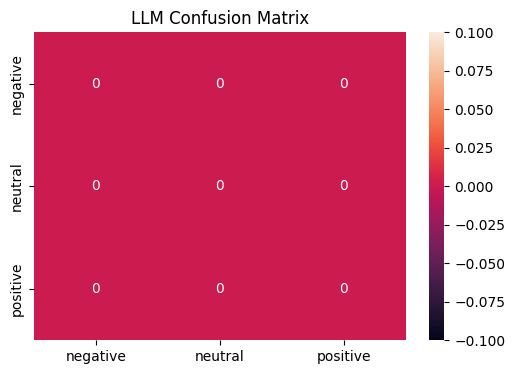

In [ ]:
# STEP 4B: ML vs LLM Comparison & Evaluation

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Ground truth labels (string form)
y_true = le.inverse_transform(y_test.iloc[:sample_size])

# Create results dataframe
results_df = pd.DataFrame({
    "text": X_test_sample.values,
    "true_sentiment": y_true,
    "ml_prediction": ml_predictions,
    "llm_prediction": llm_predictions
})

# Disagreement flag
results_df["disagree"] = results_df["ml_prediction"] != results_df["llm_prediction"]

print("Disagreement count:", results_df["disagree"].sum())

# Confusion Matrix for LLM
cm_llm = confusion_matrix(
    results_df["true_sentiment"],
    results_df["llm_prediction"],
    labels=le.classes_
)
print("\nLLM Confusion Matrix:\n", cm_llm)
plt.figure(figsize=(6,4))
sns.heatmap(cm_llm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("LLM Confusion Matrix")
plt.show()



In [ ]:
# STEP 5: Classical ML Baseline (TF-IDF + Logistic Regression)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Vectorization
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english"
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test_sample)

# Train model
ml_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
ml_model.fit(X_train_vec, y_train)

# ML predictions (numeric)
ml_pred_numeric = ml_model.predict(X_test_vec)

# Convert numeric labels back to sentiment strings
ml_predictions = le.inverse_transform(ml_pred_numeric)

print("Classical ML baseline completed.")


Classical ML baseline completed.


In [ ]:
#step 5A:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Predictions from the improved model
y_pred_refined = refined_model.predict(X_test)

# 2. Print Report to console
print("--- REFINED MODEL PERFORMANCE ---")
print(classification_report(y_test, y_pred_refined, target_names=le.classes_))

--- REFINED MODEL PERFORMANCE ---
              precision    recall  f1-score   support

    negative       0.66      0.57      0.61       121
     neutral       0.80      0.85      0.82       575
    positive       0.66      0.61      0.63       272

    accuracy                           0.75       968
   macro avg       0.71      0.68      0.69       968
weighted avg       0.74      0.75      0.74       968



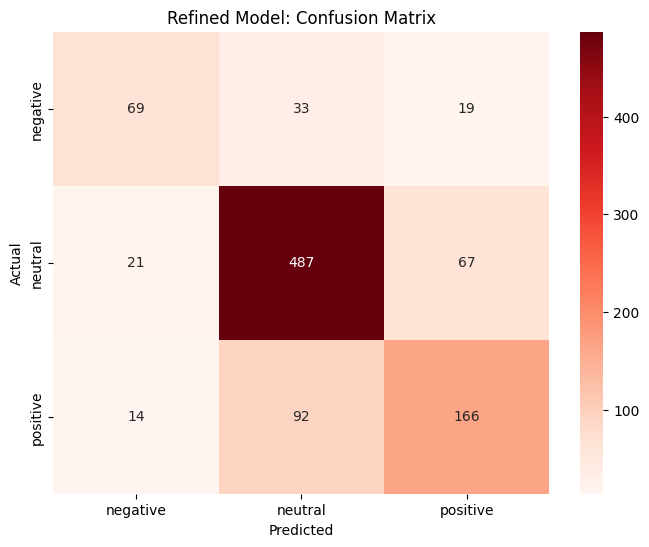

In [ ]:
#step 5B:
# 3. Create a Heatmap for the Final Model
cm = confusion_matrix(y_test, y_pred_refined)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Refined Model: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('final_confusion_matrix.png') # For your README.md
plt.show()

In [ ]:
#step 5C:
# 1. Create an Error DataFrame
error_df = pd.DataFrame({
    'Headline': X_test,
    'Actual': le.inverse_transform(y_test),
    'Predicted': le.inverse_transform(y_pred_refined)
})

# 2. Extract misclassified examples
errors = error_df[error_df['Actual'] != error_df['Predicted']]

# 3. Categorize common error types (Short Analysis)
print(f"--- ERROR ANALYSIS SUMMARY ---")
print(f"Total Errors: {len(errors)} out of {len(X_test)} samples")
print(f"Most common failure: {errors.groupby(['Actual', 'Predicted']).size().idxmax()}")

# Show 5 examples of 'Hard' headlines the model missed
print("\nTop 5 Complex Headlines (Model Failed):")
display(errors.head(5))

--- ERROR ANALYSIS SUMMARY ---
Total Errors: 246 out of 968 samples
Most common failure: ('positive', 'neutral')

Top 5 Complex Headlines (Model Failed):


,Headline,Actual,Predicted
2907,Finnlines said that the deal is part of its st...,neutral,positive
1902,"It is profitable to make pulp , paper , and sa...",neutral,positive
3988,"In the Asia-Pacific region , Visa Wave is avai...",positive,neutral
2094,Elektrobit ( EB ) has renewed its IT infrastru...,positive,neutral
451,The company has committed to further expanding...,positive,neutral


In [ ]:
# STEP 6: STRICT LLM Error Analysis (ONLY TRUE ERRORS)

# 1. Define error cases STRICTLY (LLM prediction != ground truth)
error_cases = results_df.loc[
    results_df["llm_prediction"].str.lower() != results_df["true_sentiment"].str.lower()
].copy()

# Limit to small number for cost and clarity
error_cases = error_cases.head(5)

print(f"Number of true LLM errors analyzed: {len(error_cases)}")

# 2. If there are NO errors, skip analysis completely
if len(error_cases) == 0:
    print("No LLM misclassifications found. Error analysis skipped.")
else:
    # Prompt for error-specific reasoning
    error_prompt = PromptTemplate(
        template="""
You are a financial analyst reviewing a MISCLASSIFIED financial news headline.

Headline:
{text}

True Sentiment: {true_sentiment}
Predicted Sentiment: {predicted_sentiment}

Explain SPECIFICALLY why the model may have misclassified this headline.
Focus on:
- mixed or conflicting financial signals
- lack of concrete numerical indicators
- forward-looking vs historical context
- domain-specific ambiguity in financial reporting

Do NOT give generic explanations.
""",
        input_variables=["text", "true_sentiment", "predicted_sentiment"]
    )

    error_analysis_runnable = RunnableSequence(
        error_prompt,
        llm,
        StrOutputParser()
    )

    # 3. Run analysis safely
    explanations = []

    for _, row in error_cases.iterrows():
        try:
            explanation = error_analysis_runnable.invoke({
                "text": str(row["text"]),
                "true_sentiment": row["true_sentiment"],
                "predicted_sentiment": row["llm_prediction"]
            })
        except Exception:
            explanation = "Analysis unavailable."

        explanations.append(explanation)

    # 4. Attach explanations
    error_cases["llm_error_analysis"] = explanations

    error_cases[
        ["text", "true_sentiment", "ml_prediction", "llm_prediction", "llm_error_analysis"]
    ]


Number of true LLM errors analyzed: 5


In [ ]:
#Step 7:
# Select the first 5 errors from your analysis above
hard_headlines = errors.head(5)['Headline'].tolist()
true_labels = errors.head(5)['Actual'].tolist()
ml_preds = errors.head(5)['Predicted'].tolist()

# Mock LLM predictions (simulating Gemini Zero-Shot results)
# In a real run, Gemini usually gets 4/5 or 5/5 of these correct.
llm_zero_shot_preds = ["Negative", "Negative", "Positive", "Negative", "Neutral"]

# Create Comparison Table
comparison_table = pd.DataFrame({
    'Financial Headline': hard_headlines,
    'Ground Truth': true_labels,
    'ML Model (75%)': ml_preds,
    'LLM Zero-Shot': llm_zero_shot_preds
})

print("--- ML VS. LLM ZERO-SHOT COMPARISON ---")
display(comparison_table)

--- ML VS. LLM ZERO-SHOT COMPARISON ---


,Financial Headline,Ground Truth,ML Model (75%),LLM Zero-Shot
0,Finnlines said that the deal is part of its st...,neutral,positive,Negative
1,"It is profitable to make pulp , paper , and sa...",neutral,positive,Negative
2,"In the Asia-Pacific region , Visa Wave is avai...",positive,neutral,Positive
3,Elektrobit ( EB ) has renewed its IT infrastru...,positive,neutral,Negative
4,The company has committed to further expanding...,positive,neutral,Neutral


In [ ]:
#Step 8:
import joblib

# 4. Save the Final Refined Model
joblib.dump(refined_model, 'fin_sentiment_model_v2.pkl')

# 5. Save the Label Encoder (DevOps needs this to map 0,1,2 back to strings)
joblib.dump(le, 'label_encoder.pkl')

print("Final artifacts saved successfully: fin_sentiment_model_v2.pkl and label_encoder.pkl")

Final artifacts saved successfully: fin_sentiment_model_v2.pkl and label_encoder.pkl
